In [120]:
#imports
from __future__ import division
import time
import datetime
from itertools import product
import operator

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [2]:
#global vars
NUM_QUANTILES = 10

In [150]:
def load_data(dataset):
    if dataset == "breast cancer":
        dataLoad = datasets.load_breast_cancer(return_X_y=False)
        return {"data": dataBunch.data[:,:10],
                "target": dataBunch.target,
                "feature_names": dataBunch.feature_names[:10],
                "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])},
                "target_type": "Classification"
               }     
    elif dataset == "cervical cancer":
        dataLoad = pd.read_csv("data/cervical_cancer.csv")
        target = dataLoad.Biopsy
        dataLoad = dataLoad.drop(["Person", "Biopsy"],axis=1)
        return {"data": dataLoad.values,
                "target": target,
                "feature_names": dataLoad.columns,
                "feature_locs": {x:i for i,x in enumerate(dataLoad.columns)},
                "target_type": "Classification"
               }
    elif dataset == "bike":
        def _datestr_to_timestamp(s):
            return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

        dataLoad = pd.read_csv('data/bike.csv')
        dataLoad['dteday'] = dataLoad['dteday'].apply(_datestr_to_timestamp)
        dataLoad = pd.get_dummies(dataLoad, prefix=["weathersit"], columns=["weathersit"], drop_first=False)

        #de-normalize data to produce human-readable features.
        #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
        dataLoad["hum"] = dataLoad["hum"].apply(lambda x: x*100.)
        dataLoad["windspeed"] = dataLoad["windspeed"].apply(lambda x: x*67.)
        #convert Celsius to Fahrenheit
        dataLoad["temp"] = dataLoad["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
        dataLoad["atemp"] = dataLoad["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

        #rename features to make them interpretable for novice users
        feature_names_dict = {"yr":"First or Second Year", 
                                  "season":"Season", 
                                  "hr":"Hour of Day", 
                                  "workingday":"Work Day",
                                  "weathersit_2":"Misty Weather",
                                  "weathersit_3":"Light Precipitation",
                                  "weathersit_4":"Heavy Precipitation",
                                  "temp":"Temperature (F)",
                                  "atemp":"Feels Like (F)",
                                  "hum":"Humidity",
                                  "windspeed":"Wind Speed"}
        dataLoad= dataLoad.rename(mapper=feature_names_dict,axis=1) 
        features = feature_names_dict.values()

        return {"data": dataLoad[features].values,
                "target": dataLoad["cnt"],
                "feature_names": features,
                "feature_locs": {x:i for i,x in enumerate(features)},
                "target_type": "Regression"
               }     

In [154]:
def build_classifier(data, num_estimators, model_type):
    if data["target_type"] == "Classification":
        if model_type=="random forest":
            classifier_type = RandomForestClassifier
        elif model_type=="gradient boosting":
            classifier_type = GradientBoostingClassifier
    else:
        if model_type=="random forest":
            classifier_type = RandomForestRegressor
        elif model_type=="gradient boosting":
            classifier_type = GradientBoostingRegressor       
    classifier = classifier_type(n_estimators=num_estimators, max_depth=2)
    classifier.fit(data["data"], data["target"])
    predictions = classifier.predict(data["data"])
    return classifier, r2_score(data["target"], predictions)

In [163]:
def calculate(data):

    #generate data structure for pairwise charts
    feature_pairs = {key: {"map":None,
                           "bolShow": True,
                           "predicates":[]}\
                     for key in set([tuple(sorted(t)) for t in product(data["feature_names"], repeat=2)])}
    feature_ranges = {}
    for feature in data["feature_names"]:
        loc = data["feature_locs"][feature]
        quantiles = []
        if np.unique(data["data"][:,loc]).shape[0] < 5 or type(data["data"][0,loc]) is str:
            quantiles = np.unique(data["data"][:,loc])
        else:
            quantiles = np.around(np.unique(np.quantile(a=data["data"][:,loc], q=np.linspace(0, 1, NUM_QUANTILES))),4)
        feature_ranges[feature] = quantiles

    def get_quantile_matrix(feat1, feat2):
        h = list(feature_ranges[feat1])*len(feature_ranges[feat2])
        v = [item for item in list(feature_ranges[feat2])\
             for i in range(len(feature_ranges[feat1]))]                        
        return h,v 

    def get_leaf_value(model, node_position):
        if data["target_type"]=="Classification":
            return model.tree_.value[node_position][0][1]/\
                        (model.tree_.value[node_position][0][1] + model.tree_.value[node_position][0][0])
        else:
            return model.tree_.value[node_position]

    for key, value in feature_pairs.iteritems():
        h, v = get_quantile_matrix(key[0], key[1])
        value["map"]=np.array([{key[0]:x, key[1]:y}\
                               for x,y in zip(h,v)])\
        .reshape(len(feature_ranges[key[0]]), len(feature_ranges[key[1]]))

    for modelT in classifier.estimators_:
        if data["target_type"] == "Regression":
            model = modelT[0]
        else:
            model = modelT
        feature_ids = {i:{"number":x, "name":data["feature_names"][x]}\
                          for i,x in enumerate(list(model.tree_.feature)) if x>=0} #-2 means leaf node

        #need to refactor this part to condense code and prepare for handling higher-depth trees

        #for 1-layer trees
        if model.tree_.feature[1] <0:
            feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[0]["name"]]))
            decision_func_dict = {
                "feature_name": feature_ids[0]["name"],
                "threshold": model.tree_.threshold[0],
                "operator": operator.le,
                "prob_le": get_leaf_value(model,1),
                "prob_gt": get_leaf_value(model,2)
            }       
            #build the predictive function used in the decision tree
            def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                if decision_func_dict["operator"](\
                                                    data_case[decision_func_dict["feature_name"]],\
                                                    decision_func_dict["threshold"]\
                                                   ):
                    return decision_func_dict["prob_le"]
                else:
                    return decision_func_dict["prob_gt"]        
        else:
            for node_position in [1,4]: #positions for left and right nodes at layer 2
                if node_position in feature_ids:
                    feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[node_position]["name"]]))
                    #get the decision rules
                    decision_func_dict = {
                        "feature_name_1": feature_ids[0]["name"],
                        "threshold_1": model.tree_.threshold[0],

                        "operator_1": operator.le if node_position == 1 else operator.gt,

                        "feature_name_2": feature_ids[node_position]["name"],
                        "threshold_2": model.tree_.threshold[node_position],

                        "operator_2": operator.le,

                        "prob_le": get_leaf_value(model,node_position+1),

                        "prob_gt": get_leaf_value(model,node_position+2)
                    }
                    #build the predictive function used in the decision tree
                    def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                        if decision_func_dict["operator_1"](\
                                                            data_case[decision_func_dict["feature_name_1"]],\
                                                            decision_func_dict["threshold_1"]\
                                                           ):
                            if decision_func_dict["operator_2"](\
                                                                data_case[decision_func_dict["feature_name_2"]],\
                                                                decision_func_dict["threshold_2"]\
                                                               ):
                                return decision_func_dict["prob_le"]
                            else:
                                return decision_func_dict["prob_gt"]
                        else:
                            return 0.

                else: #asymmetric tree, this is a leaf node
                    feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[0]["name"]]))
                    decision_func_dict = {
                        "feature_name": feature_ids[0]["name"],
                        "threshold": model.tree_.threshold[0],
                        "operator": operator.le if node_position == 1 else operator.gt,

                        "prob_le": 1. if node_position == 1 else 0.,

                        "prob_gt": 0. if node_position == 1 else 1.,
                    }       
                    #build the predictive function used in the decision tree
                    def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                        if decision_func_dict["operator"](\
                                                            data_case[decision_func_dict["feature_name"]],\
                                                            decision_func_dict["threshold"]\
                                                           ):
                            return decision_func_dict["prob_le"]
                        else:
                            return decision_func_dict["prob_gt"]                  

            feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)
            
    #now calculate output array for each feature pair
    for key, value in feature_pairs.iteritems():
        arrs = []
        for predicate in value["predicates"]:
            f = np.vectorize(predicate)
            arrs.append(f(value["map"]))
        if len(arrs) > 0:
            #details of vote aggreggation method for random forest
            #hpairttps://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
            value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)
        else:
            value["output"] = None
            
    #build chart data
    for key, value in feature_pairs.iteritems():
        h,v = get_quantile_matrix(key[0], key[1])
        value["H_Indices"] = h
        value["V_Indices"] = v
        value["Votes"] = value["output"].ravel() if value["output"] is not None else None
        
    output_details = {"offset":0,
                      "no_predictor_features":[],
                      "low_variance_features":[],
                      "low_impact_features":[],
                      "zero_features":[]}
    for key, value in feature_pairs.iteritems(): 
        if value["Votes"] is None:
            value["bolShow"] = False
            output_details["no_predictor_features"].append(key)
        else:
            srs = pd.Series(value["Votes"])
            if srs.apply(lambda x: x==0.).all():
                value["bolShow"] = False
                output_details["zero_features"].append(key)
            elif abs(srs.std()/srs.mean()) < 0.1:
                print "low std: " + str(key)
                output_details["offset"] += srs.mean()
                value["bolShow"] = False
                output_details["low_variance_features"].append(key)
            elif srs.max() < (1. if data["target_type"]=="Classification" else np.mean(data["target"])/10.):
                output_details["offset"] += srs.mean()
                value["bolShow"] = False
                output_details["low_impact_features"].append(key)
            else:
                #build dataframe for chart
                value["chart_df"] = pd.DataFrame(dict((x, value[x]) for x in ["H_Indices", "V_Indices", "Votes"]))
    
    
    return feature_pairs, feature_ranges, output_details

In [173]:
def generate_chart(data):
    i = 1
    rows = []
    charts = []
    for key, value in chart_data.iteritems():
        if value["bolShow"]:
            x_encoding = alt.X(field="H_Indices",\
                               type="ordinal", sort="ascending",
                               axis=alt.Axis(title=key[0]))
            y_encoding = alt.Y(field="V_Indices",\
                               type="ordinal", sort="descending",
                               axis=alt.Axis(title=key[1]))

            color_encoding = alt.Color(field= "Votes",
                                       type="quantitative",
                                       scale=alt.Scale(scheme="greenblue"),
                                       legend=alt.Legend(title="Votes"))
            charts.append(alt.Chart(\
                                    data=value["chart_df"])\
                          .mark_rect()\
                          .encode(x=x_encoding, y=y_encoding, color=color_encoding)\
                          .properties(width=150, height=150)
                         )
            if i%3==0:
                rows.append(alt.hconcat(*charts))
                charts = []
            i += 1
    return alt.vconcat(*rows)

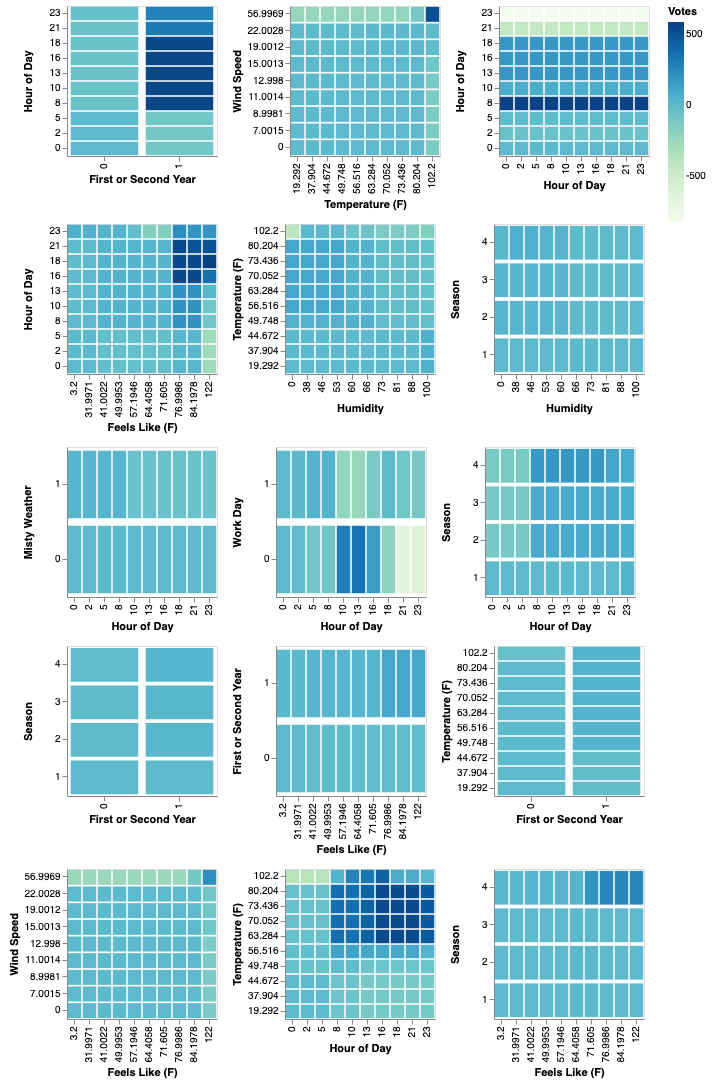

In [174]:
data_to_use = load_data("bike")
classifier, accuracy = build_classifier(data_to_use, 300, "gradient boosting")
chart_data, feature_ranges, output_details = calculate(data_to_use)
generate_chart(chart_data)